In [1]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display
from time import localtime, strftime

%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, Flatten, Activation, Lambda, Convolution1D, Dense, BatchNormalization, add
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from geographiclib.geodesic import Geodesic

from numpy.fft import fft, ifft
from tensorflow.keras.utils import to_categorical
from scipy.special import softmax

model_folder='models/'
log_folder='logs/'

# BazNET: 3C Backazimuth Estimation with DNNs


Back Azimuth estimation is a critical step in seismic signal processing pipeline, feeding the downstream processes that associate events and build location estimates. Typically, there are two methods of estimating backazimuth, depending on the type of station. If the station consists of an array of instruments, the backazimuth can be estimated by the time-delay of arrival (TDOA) across the array. This process is called beamforming, and produces backazimuth estimates that can be quite accurate. If the station consists of a single 3-channel (3C) instrument with North-South, East-West and Vertical channels, the backazimuth can be estimated by calculating the polarization of the arriving wavefront. This process produces much less accurate results.

In this work, we attempt to create an alternative to polarization analysis, that is on-par with the accuracy of beamforming. Such an acheivement could greatly improve the association and location estimates for a seismic network, by taking full advantage of the much more prolific and inexpensive 3C stations. In particular, we utilize a deep neural network to directly estimate the backazimuth from a 3C waveform. This is accomplished by training the network against 10 years of historical data from the station.

This technique does not generalize across stations, and in fact, it does not even generalize for new source locations at an existing station. However, the estimates for most signals are quite accurate, rivaling those found through beamforming an entire array.

We now proceed to detail and demonstrate this technique as follows:

- STEP 1: Data Exploration
- STEP 2: Traditional Methodology
- STEP 3: Proposed Methodology
- STEP 4: Training
- STEP 5: Testing



*** 

## STEP 1: DATA EXPLORATION

The dataset used in this study includes both the catalog and raw waveform data for all associated event arrivals from the IDC database for a single 3C station, STKA, across a 10-year period from 1/1/2009 to 1/1/2019. STKA is a 3C seismic station located in southern Australia. This data is contained in two files: a csv file containing a catalog of seismic arrivals, and a numpy array containing the corresponding arrival waveform data, as given below: 

- Y\_STKA\_20\_180.csv -- _(Arrival Catalog)_
- X\_STKA\_20\_180.npy -- _(Waveform Data)_

In order to compare our results to those obtained with a beamforming, we also include an arrival catalog for a nearby array station, ASAR, located in Central Australia. This catalog includes the beamformed azimuth estimates made by the IDC.

- Y\_ASAR\_20\_180.csv -- _(Arrival Catalog)_


### _Arrival Catalog:_

The catalog contains numerous details for each arrival, but here we are concerned primarily with the location coordinates for the event epicenter and the recording station, given by the following columns: __EV_LAT__, __EV_LON__, __ST_LAT__ and __ST_LON__. We are also interested in the __AZI_PRED__ column, which is the backazimuth estimate predicted by the automatic processing algorithms at the IDC. 

It is important to note that for the 3C station, STKA, the __AZI_PRED__ estimates were made by polarization analysis, while for the array station, ASAR, the __AZI_PRED__ estimates were made by beamforming. 


In [2]:
def read_cat(cat_file):
    cat = pd.read_csv(cat_file)
    cat['TIME'] = pd.to_datetime(cat['TIME'])
    return cat

In [3]:
cat_CPUP = read_cat('data/Y_CPUP_20_180.csv')
cat_ASAR = read_cat('data/Y_ASAR_20_180.csv')
display(cat_CPUP.STA.value_counts())
display(cat_ASAR.STA.value_counts())

CPUP    51385
Name: STA, dtype: int64

ASAR    421297
Name: STA, dtype: int64

***

## STEP 2: TRADITIONAL METHODOLOGY

We explore traditional backazimuth estimation in three parts:

1) Backazimuth Definition

2) Beamforming Analysis

3) Polarization Analysis

### _Backazimuth Definition:_

Before we can begin estimating Baz, we must define it precisely. For the purposes of this study, Baz is the great circle bearing for the event epicenter, referenced at the recording station in clockwise degrees from north. The following diagram illustrates the backazimuth for an event epicenter located in the south Pacific and a recording station in London, England:

<img src="images/BackAzimuthDiagram.png" width="300px">

This diagram demonstrates the azimuth (Az) and backazimuth (Baz) angles for the given Event-Station pair. The latitude and longitude coordinates for the station, in radians, are given by $(\phi_s, \lambda_s)$, while the event coordinates are given by $(\phi_s, \lambda_s)$.

Assuming a spherical earth, simple trigonometry can be used to calculate the backazimuth, as shown in both formula and code:

***
**formula:**

$y = \sin(\lambda_e - \lambda_s) * \cos(\phi_e)$

$x =  \sin(\phi_e) * \cos(\phi_s) - \sin(\phi_s) * \cos(\phi_e) * \cos(\lambda_e - \lambda_s)$

$Baz = atan2(y, x)$

***
**code:**

 ```py
def Baz(lonS, latS, lonE, latE):

    # convert decimal degrees to radians    
    lonS, latS, lonE, latE = map(radians, [lonS, latS, lonE, latE])
    dLon = lonE - lonS
    
    y = sin(lonE - lonS) * cos(latE)
    x = cos(latS) * sin(latE) - sin(latS) * cos(latE) * cos(lonE - lonS)
    
    deg = degrees(atan2(y, x))
    if deg < 0:
        deg = 360 + deg
    return deg
```
***


While the code above is servicable, a faster, more robust implementation, which takes into account the elliptical nature of the earth, can be found in the geographiclib python package. We utilize this implementation here, adapting it for use with our seismic catalogs. The code below appends the true backazimuth to each row of the catalog, creating a new column, __AZI_TRUE__. 

In [4]:
def azimuther(cat_row):
    return Geodesic.WGS84.Inverse(cat_row.EV_LAT, cat_row.EV_LON, cat_row.ST_LAT, cat_row.ST_LON)['azi2'] + 180

In [5]:
cat_CPUP['AZI_TRUE'] = cat_CPUP.apply(lambda row: azimuther(row), axis=1)
cat_ASAR['AZI_TRUE'] = cat_ASAR.apply(lambda row: azimuther(row), axis=1)

### _Beamforming Analysis:_

Array stations are capable of producing highly accurate backazimuth estimates using a TDOA technique called beamforming. To illustrate, the figure below maps the site locations for ASAR, a 20 element seismic array located near Alice Springs, Australia. Annotated on the map is the backazimuth for an event which originated approximately 323 miles to the southwest. Additionally, the arriving waveforms are displayed for each site.

<img src="images/Beamform_wave.png" width="700px">
<img src="images/Beamform_map.png" width="700px">

We now evaluate the accuracy of beamforming, by comparing the beamformed estimates made by the IDC (**AZI_PRED**) to the true values (**AZI_TRUE**). 

To do this, we first need to develop some apparatus for comparing angluar errors. We cannot simply take the mean squared error or even the mean absolute error, because of the circular nature of angle measures. For instance, the absolute error between 1 and 359 degrees is 358, while the angular difference is only 2. The vectorized code below takes care of this for us with great efficiency, and we employ it against our catalog.

In [6]:
def ang_diff(a, b):
    return np.min(np.stack(((a-b)%360, (b-a)%360)), axis=0)

In [7]:
cat_ASAR['AZI_IDC_ERR'] = ang_diff(cat_ASAR.AZI_TRUE.values, cat_ASAR.AZI_PRED.values)

We now plot a histogram of the residuals, and calculate both the mean and median error

In [8]:
def plot_ERR(err, lbl='', ax=None, deg_per_bin=5, lbl_rate=3):
    ax = ax or plt.gca()
    ax.cla()
    
    weights = np.ones_like(err)/float(len(err))
    bins = np.linspace(0,180,int(180/deg_per_bin + 1))
    ticks = [f'{int(t)}°' if not i%lbl_rate else '' for i, t in enumerate(bins)]
    
    _ = ax.hist(err, bins=bins, weights=weights)

    textstr = f'mean:    {err.mean():02.0f}°\nmedian: {err.median():02.0f}°'
    ax.text(180, .52, textstr, ha='right', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Absolute Backazimuth Error')
    ax.set_ylabel('Density')
    ax.set_ylim(0,.55)
    ax.set_xticks(bins)
    ax.set_xticklabels(ticks, rotation=40)
    
    plt.savefig(f'images/err_histogram_{lbl}.png', transparent=False, dpi=300, bbox_inches='tight')

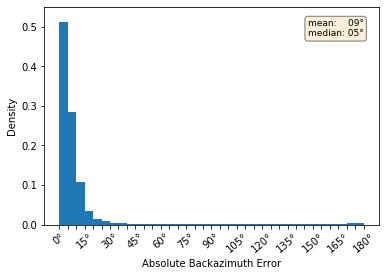

In [9]:
plot_ERR(cat_ASAR['AZI_IDC_ERR'], 'IDC_beam')

### _Polarization Analysis:_

Traditionally, backazimuth estimates for 3C stations are made by polarization analysis, which uses eigen-decomposition to look at the rectilinearity of the arriving plane wave. This gives an estimate of the polarization angle, which can be interpreted as the backazimuth. This technique is much less accurate than beamforming, as demonstrated by the histogram below:

In [10]:
cat_CPUP['AZI_IDC_ERR'] = ang_diff(cat_CPUP.AZI_TRUE.values, cat_CPUP.AZI_PRED.values)

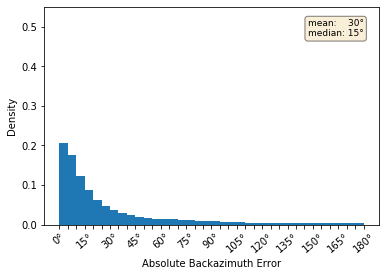

In [11]:
plot_ERR(cat_CPUP['AZI_IDC_ERR'], 'IDC_polar')

***

## STEP 3: PROPOSED METHODOLOGY

We propose an alternative to polarization analysis using machine learning against raw 3C waveforms, with a convolutional neural network. The technique we propose makes no claim to generalizability. It must be trained on a per-station basis, and it must have access to a large historical training dataset with numerous examples of all types of waveforms expected in the test set. For example, if the training set does not contain any example waveforms from a particular mine or fault-line, it would be unreasonable to expect the network to accurately estimate the backazimuths for events from that mine or fault in operation. However, given sufficient training data, the proposed algorithm is capable of significantly improving the backazimuth estimates for 3C stations.

Our methodology will be introduced in three sections:

1) Angle Representation

2) Neural Network Architecture

3) Data Generator

### _Angle Representation:_

Estimating an angle is an interesting area of research in its own right. Due to the circular nature of angles, simple regression with mean-squared error loss against degrees is inappropriate. In this work, we instead represent angles in terms of discrete bins, and utilize softmax loss. This representation allows us to take advantage of the confidence intervals associated with the softmax function, but suffers performance-wise, due to the arbitrary nature of the bin cutoffs. To remedy this, we utilize an enseble of bins. 

Of course, we must build up the apparatus to handle the transformations from one representation to the other, which we do now:

In [14]:
def deg2bins(deg, nb_bins, nb_ensb, plot=False):
    sz_bins = 360 / nb_bins
    sz_shft = sz_bins / nb_ensb
    
    deg = np.expand_dims(deg, 1)
    bins = (np.repeat(deg, nb_ensb, 1) - [i * sz_shft for i in range(nb_ensb)]) // sz_bins
    
    if plot:
        fig, ax = plt.subplots(nb_ensb, 1)
        for i in range(nb_ensb):
            st = i * sz_shft
            ax[i].set_xlim(0, 360)
            ax[i].axvline(deg[0], c='red')
            for j in range(nb_bins):
                ax[i].axvline(j * sz_bins + st)

    return np.mod(bins, nb_bins).astype('int')


def bins2deg(bins, nb_bins, nb_ensb):
    sz_bins = 360 / nb_bins
    bin_shft = nb_bins / 2

    deg_ensb1 = np.mod((bins + [i / nb_ensb for i in range(nb_ensb)] + 0.5) * sz_bins, 360)
    deg1 = np.mean(deg_ensb1, 1)

    deg_ensb2 = (np.mod(bins + bin_shft, nb_bins) + [i / nb_ensb for i in range(nb_ensb)] + 0.5) * sz_bins
    deg2 = np.mod(np.mean(deg_ensb2, 1) - bin_shft * sz_bins, 360)

    return np.where(np.var(deg_ensb1, 1) < np.var(deg_ensb2, 1), deg1, deg2)

The number of bins and ensebles are key hyperparameters that will affect performance, here, we simply look at their effect on lossiness as a representation:

(6.0, 0.0)

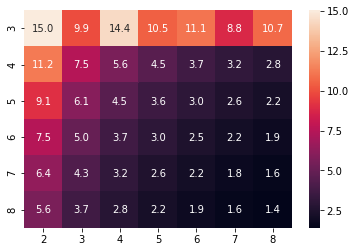

In [16]:
deg_orig = np.random.rand(10000)*360
err = pd.DataFrame()

for nb_bins in range(3,9):
    for nb_ensb in range(2,9):
        bins = deg2bins(deg_orig, nb_bins, nb_ensb)
        deg_pred = bins2deg(bins, nb_bins, nb_ensb)
        err.loc[nb_bins, nb_ensb] = np.mean(ang_diff(deg_orig, deg_pred))
        
ax = sns.heatmap(err, annot=True, fmt=".01f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

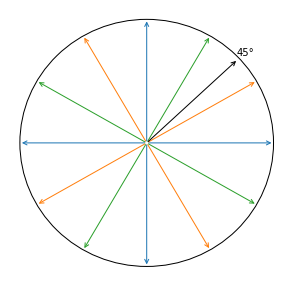

In [17]:
from math import radians, degrees, cos, sin
nb_bins = 4
nb_ensb = 3
sz_bins = 360 / nb_bins
sz_shft = sz_bins / nb_ensb

fig, ax= plt.subplots(figsize=(5,5))
ax.add_artist(plt.Circle((0,0),1, color='black', fill=False))
for i, shft in enumerate([i*sz_shft for i in range(nb_ensb)]):
    for theta in [i*sz_bins + shft for i in range(nb_bins)]:
        x = cos(radians(theta))
        y = sin(radians(theta))

        ax.annotate("", xy=(x, y), xytext=(0, 0), arrowprops=dict(arrowstyle="->", fc=f'C{i}', ec=f'C{i}'))
        ax.set_ylim((-1.1,1.1))
        ax.set_xlim((-1.1,1.1))
        ax.axis('off')
theta = 45
ax.annotate(f'{int(theta)}°', xy=(0,0), xytext=(sin(radians(theta)), cos(radians(theta))), xycoords='data', arrowprops=dict(arrowstyle="<-", fc='black', ec='black'))

plt.savefig(f'images/M-N_discretization.png', transparent=False, dpi=300, bbox_inches='tight')


### _Neural Network Architecture:_

We utilize a temporal convolutional neural network architecture first expounded in the WaveNET study. We adapt the Keras code implementation made available by [Philippe Rémy](https://github.com/philipperemy/keras-tcn).

<img src="images/ShiftEncoder.png" width="700px">


In [18]:
def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, dropout_rate=0):

    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = add([prev_x, x])
    return res_x, x


def base_model(win_len, nb_chan, nb_filters, filter_len, dilations, nb_stacks, nb_bins, nb_ensb,
               padding='causal', drop=0.05):

    input_layer = Input(shape=(win_len, nb_chan))

    x = input_layer

    x = Convolution1D(nb_filters, 1, padding=padding)(x)
    skip_connections = []
    for s in range(nb_stacks):
        for d in dilations:
            x, skip_out = residual_block(x,
                                         dilation_rate=d,
                                         nb_filters=nb_filters,
                                         kernel_size=filter_len,
                                         padding=padding,
                                         dropout_rate=drop)
            skip_connections.append(skip_out)

    x = add(skip_connections)
    x = Lambda(lambda tt: tt[:, -1, :])(x)
#     x = Dense(45)(x)
#     x = Dense(45)(x)

    if nb_ensb == 0:
        x = Dense(2)(x)
        output_layer = Lambda(lambda xx: K.l2_normalize(xx, axis=1))(x)
    else:
        output_layer = []
        for i in range(nb_ensb):
            output_layer.append(Dense(nb_bins, activation='softmax')(x))

    model = Model(input_layer, output_layer)

    return model

### _Data Generator:_

Estimating an angle is an interesting area of research in its own right. Due to the circular nature of angles, simple regression with mean-squared error loss against degrees is inappropriate. In this work, we instead represent angles in terms of discrete bins, and utilize softmax loss. This representation allows us to take advantage of the confidence intervals associated with the softmax function, but suffers performance-wise, due to the arbitrary nature of the bin cutoffs. To remedy this, we utilize an ensebl

In [19]:
def gen(cat, dat, pdict, orig_pre=20, samp_rate=40, all=False):
    bs = pdict['bs']
    pre_trim = pdict['pre']
    post_trim = pdict['post']
    nb_bins = pdict['numB']
    nb_ensb = pdict['numE']
    jitter = pdict['sh']
    jabber = pdict['numSH']
    if all:
        jitter = 0
        jabber = 1

    bs = int((bs // nb_bins + 1) * nb_bins)
    print(bs)
    sub_bs = int(bs / nb_bins)
    win = (pre_trim + post_trim) * samp_rate
    start = orig_pre - pre_trim - 0.5 * jitter
    big_cat = cat.copy(deep=True)
    big_cat['PRED_BINS'] = deg2bins(big_cat.AZI_TRUE.values, nb_bins, 1)

    while 1:
        X = []
        st = ((start + np.random.rand(jabber) * jitter) * samp_rate).astype('int')
        en = st + win
        if all:
            my_cat = cat
        else:
            my_cat = []
            for i in range(nb_bins):
                my_cat.append(big_cat.loc[big_cat.PRED_BINS == i].sample(sub_bs))
            my_cat = pd.concat(my_cat)

        for i in range(jabber):
            X.append(np.take(dat, my_cat.index, axis=0)[:, st[i]:en[i], :])
        X = np.vstack(X)

        if nb_ensb == 0:
            Y = deg2xy(my_cat.AZI_TRUE.values)
            Y = np.vstack([Y] * jabber)
        else:
            Y = deg2bins(my_cat.AZI_TRUE.values, nb_bins, nb_ensb)
            Y = to_categorical(Y, nb_bins)
            Y = np.vstack([Y] * jabber)

        if nb_ensb > 1:
            Y = list(np.swapaxes(Y, 0, 1))
        elif nb_ensb == 1:
            Y = [Y]

        yield X, Y


***

## STEP 4: TRAINING

We propose an alternative to polarization analysis using machine learning against raw 3C waveforms, with a convolutional neural network. The technique we propose makes no claim to generalizability. It must be trained on a per-station basis, and it must have access to a large historical training dataset with numerous examples of all types of waveforms expected in the test set. For example, if the training set does not contain any example waveforms from a particular mine or fault-line, it would be unreasonable to expect the network to accurately estimate the backazimuths for events from that mine or fault in operation. However, given sufficient training data, the proposed algorithm is capable of significantly improving the backazimuth estimates for 3C stations.

Our training code will be introduced in three sections:

1) Train/Val/Test Splits

2) Parameter Dictionaries and Model Logistics

3) Training

### _Train/Val/Test Splits:_

We divide this data into three partitions: train, validate and test, using the final year (2018) for testing and the previous two years (2016 and 2017) for validation. 


In [20]:
def DAT_normalize(X):
    X = X / np.expand_dims(np.expand_dims(np.abs(X).max(1).max(1), 1), 1)
    return X

In [21]:
dat = DAT_normalize(np.load('data/X_CPUP_20_180.npy'))

In [23]:
cat_trn = cat_CPUP.loc[cat_CPUP.TIME < '01-01-2016']
dat_trn = np.take(dat, cat_trn.index, axis=0)
cat_trn.reset_index(drop=True, inplace=True)

cat_val = cat_CPUP.loc[(cat_CPUP.TIME > '01-01-2016') & (cat_CPUP.TIME < '01-01-2018')]
dat_val = np.take(dat, cat_val.index, axis=0)
cat_val.reset_index(drop=True, inplace=True)

cat_tst = cat_CPUP.loc[(cat_CPUP.TIME > '01-01-2018')]
dat_tst = np.take(dat, cat_tst.index, axis=0)
cat_tst.reset_index(drop=True, inplace=True)

### _Parameter Dictionaries and Model Logistics:_

The code below functions to save and load the models in an orderly fashion:


In [24]:
def param2name(pdict):
    name = []
    for key in pdict.keys():
        if type(pdict[key]) is list:
            name.append(f'{key}:{"x".join(map(str, pdict[key]))}')
        else:
            name.append(f'{key}:{pdict[key]}')
    return '|'.join(name)
           
                        
def name2param(name):
    name = name[:-3]
    regnumber = re.compile(r'^\d+(\.\d+)?$')
    pdict = dict([p.split(':') for p in name.split('|')])
    for key in pdict.keys():
        if regnumber.match(pdict[key]):
            try:
                pdict[key] = int(pdict[key])
            except:
                pdict[key] = float(pdict[key])
        else:
            if 'x' in pdict[key]:
                pdict[key] = list(map(int, pdict[key].split('x')))
            try:
                pdict[key] = float(pdict[key])
            except:
                pass
    return pdict

In [25]:
def load_custom_model(pdict, model_folder='models'):
    if 'iniW' in pdict.keys():
        model_name = [n for n in os.listdir(model_folder) if f"|time:{pdict['iniW']}" in n][0]
        model_file = os.path.join(model_folder, model_name)

        print('loading previous model:\n', model_file)
        pdict = name2param(os.path.basename(model_file))
        model = load_model(model_file)
    else:
        model_name = param2name(pdict)
        model_file = os.path.join(model_folder, model_name)

        print('building new model:\n', model_file)
        model = base_model(win_len=(pdict['pre'] + pdict['post']) * 40,
                           nb_chan=3,
                           nb_filters=pdict['f'],
                           filter_len=pdict['k'],
                           dilations=pdict['d'],
                           nb_stacks=pdict['s'],
                           nb_bins=pdict['numB'],
                           nb_ensb=pdict['numE'])
    return model, model_name


def compile_custom_model(model, pdict):
    o = Adam(lr=pdict['lr'], clipnorm=1.)
    if pdict['numE'] == 0:
        model.compile(loss='mse', optimizer=o, metrics=['mae'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=o, metrics=['categorical_accuracy'])

    return model, param2name(pdict)


def get_callbacks(model_name, model_folder, log_folder):
    pdict = name2param(os.path.basename(model_name))
    tensor_foldername = os.path.join(log_folder, model_name)
    model_filename = os.path.join(model_folder, model_name + '.h5')

    sv = ModelCheckpoint(filepath=model_filename, monitor='val_loss', save_best_only=True,
                                         save_weights_only=False, mode='min')
    tbd = TensorBoard(log_dir=tensor_foldername)
    stp = EarlyStopping(monitor='val_loss', min_delta=0, patience=pdict['pat'],
                                        verbose=0, mode='min', baseline=None)

    return [sv, tbd, stp]


### _Model Training:_

The code below trains a model:


In [26]:
# Model Parameters
pdict = {}
pdict['f']     = 45
pdict['k']     = 15
pdict['d']     = [2, 4, 8, 16, 32]
pdict['s']     = 1

# Dataset Parameters
pdict['sta']   = 'CPUP'
pdict['pre']   = 3
pdict['post']  = 17

# Training Parameters
pdict['sh']    = 3
pdict['numSH'] = 12
pdict['bs']    = 50
pdict['numB']  = 3
pdict['numE']  = 15
pdict['lr']    = .0005
pdict['pat']   = 4
pdict['time']  = strftime("%y-%m-%d-%H-%M-%S", localtime())

In [27]:
# Instantiate the Generator Functions
trn_gen = gen(cat_trn, dat_trn, pdict)
val_gen = gen(cat_val, dat_val, pdict)

t_step = len(cat_trn) // pdict['bs'] + 1
v_step = len(cat_val) // pdict['bs'] + 1

In [28]:
# Build the Model
print('loading model...', end=' ', flush=True)
model, model_name = load_custom_model(pdict)
pdict = name2param(model_name)
model, _ = compile_custom_model(model, pdict)
print('complete')
print(model.summary())

model, model_name = compile_custom_model(model, pdict)
print(model_name)
model_id = pdict['time']

loading model... building new model:
 models/f:45|k:15|d:2x4x8x16x32|s:1|sta:CPUP|pre:3|post:17|sh:3|numSH:12|bs:50|numB:3|numE:15|lr:0.0005|pat:4|time:19-11-14-10-25-57
complete
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 45)      180         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 800, 45)      30420       conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Ac

f:45|k:15|d:2x4x8x16x32|s:1|sta:CPUP|pre:3|post:17|sh:3|numSH:12|bs:50|numB:3|numE:15|lr:0.0005|pat:4|time:19-11-14-10-25


In [ ]:
history = model.fit_generator(trn_gen, steps_per_epoch=t_step, epochs=5000,
                              validation_data=val_gen, validation_steps=v_step,
                              callbacks=get_callbacks(model_name, model_folder, log_folder),
                              max_queue_size=10)

***

## STEP 5: TESTING



In [29]:
pdict = {}
pdict['iniW'] = model_id
pdict['iniW'] = '19-10-29-12-25'
model, model_name = load_custom_model(pdict)
pdict = name2param(model_name)
tst_gen = gen(cat_tst, dat_tst, pdict, all=True)
X_tst, Y_tst = next(tst_gen)
pred = np.asarray(model.predict(X_tst))

loading previous model:
 models/f:45|k:15|d:2x4x8x16x32|s:1|sta:CPUP|pre:3|post:17|sh:3|numSH:12|bs:50|numB:3|numE:15|lr:0.0005|pat:4|time:19-10-29-12-25.h5
51


In [44]:

d, c = bins2degs(np.swapaxes(pred, 0, 1), pdict['numB'], pdict['numE'])
cat_tst["Certainty"] = tst_conf
cat_tst['Certainty Range'] = pd.qcut(cat_tst["Certainty"], 8)
cat["AZI_PRED_NN"] = tst_degs
cat["Absolute Backazimuth Error"] = ang_diff(cat.AZI_TRUE.values, cat["AZI_PRED_NN"].values)

In [46]:
pred.shape

(15, 5414, 3)

In [32]:
def test_model(model_id, cat=None, dat=None, plot=False, q=8):

    pdict = {}
    pdict['iniW'] = model_id
    model, model_name = load_custom_model(pdict)
    pdict = name2param(model_name)

    if cat is None:
        sta = pdict['sta']
        cat = read_cat(f'data/Y_{sta}_20_180.csv')
        dat = DAT_normalize(np.load(f'data/X_{sta}_20_180.npy'))
        cat = cat.loc[(cat.TIME > '01-01-2018')]
        dat = np.take(dat, cat.index, axis=0)
        cat.reset_index(drop=True, inplace=True)
        pdict['data'] = 'TEST'
    else:
        cat = cat.copy()
    print(len(cat), len(dat))
    tst_gen = gen(cat, dat, pdict, all=True)
    X_tst, Y_tst = next(tst_gen)
    pred = np.asarray(model.predict(X_tst))

    if pdict['numE'] == 0:
        tst_degs = xy2deg(pred)
    else:
        if len(pred.shape) < 3:
            pred = np.expand_dims(pred, 0)
        tst_bins = np.argmax(np.swapaxes(pred, 0, 1), axis=2)
        tst_degs = bins2deg(tst_bins, pdict['numB'], pdict['numE'])
        tst_conf = np.min(np.max(np.swapaxes(pred, 0, 1), axis=2), axis=1)

        cat['AZI_CERTAINTY'] = tst_conf
        cat['AZI_CERTAINTY_RANGE'] = pd.qcut(cat['AZI_CERTAINTY'], q)


    cat['AZI_PRED_NN'] = tst_degs
    cat['AZI_ERR_NN'] = ang_diff(cat.AZI_TRUE.values, cat['AZI_PRED_NN'].values)

    if plot:
        plot_ERR(cat['AZI_ERR_NN'], f'{model_id}')

    mean = cat['AZI_ERR_NN'].mean()
    median = cat['AZI_ERR_NN'].median()
    print('mean:', mean, '\nmedian:', median)
    update_results(pdict, mean, median)

    return cat

loading previous model:
 models/f:45|k:15|d:2x4x8x16x32|s:1|sta:CPUP|pre:3|post:17|sh:3|numSH:12|bs:50|numB:4|numE:8|lr:0.0005|pat:8|time:19-09-16-14-09.h5
5414 5414
52
mean: 30.75103274514566 
median: 11.454818373066544


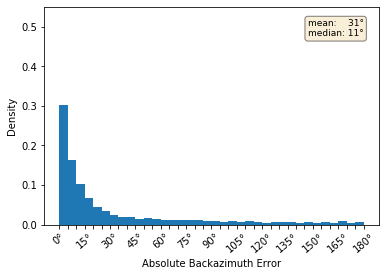

In [34]:
model_id = '19-09-16-14-09'
cat_tst = test_model(model_id, cat_tst, dat_tst, True)